In [1]:
from sklearn import metrics
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import time
import matplotlib.pyplot as plt
plt.cla()   # Clear axis
plt.clf()   # Clear figure
plt.close('all')

df = pd.read_csv('../input/mobile-health/mhealth_raw_data.csv')
print(df.info())




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215745 entries, 0 to 1215744
Data columns (total 14 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   alx       1215745 non-null  float64
 1   aly       1215745 non-null  float64
 2   alz       1215745 non-null  float64
 3   glx       1215745 non-null  float64
 4   gly       1215745 non-null  float64
 5   glz       1215745 non-null  float64
 6   arx       1215745 non-null  float64
 7   ary       1215745 non-null  float64
 8   arz       1215745 non-null  float64
 9   grx       1215745 non-null  float64
 10  gry       1215745 non-null  float64
 11  grz       1215745 non-null  float64
 12  Activity  1215745 non-null  int64  
 13  subject   1215745 non-null  object 
dtypes: float64(12), int64(1), object(1)
memory usage: 129.9+ MB
None


In [2]:
train_data = pd.read_csv('../input/human-activity-recognition-with-smartphones/train.csv')
test_data = pd.read_csv('../input/human-activity-recognition-with-smartphones/test.csv')


In [3]:
pd.set_option("display.max_columns", None)

In [4]:
train_data['Activity'].unique()

array(['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

<AxesSubplot:>

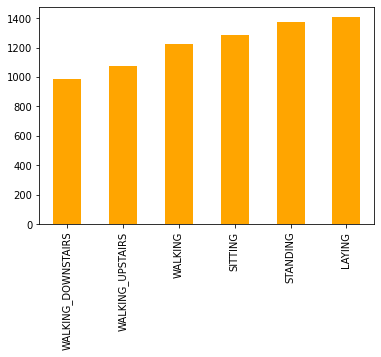

In [5]:
train_data['Activity'].value_counts().sort_values().plot(kind = 'bar', color = 'orange')

In [6]:
def show_plot (df,df_target,plot_size,time_point, plt_title):
    plt.figure()
    if time_point < plot_size/2:
        left_point = 0
    else:
        left_point  = int(time_point-plot_size/2)
    if time_point > len(df) - plot_size/2:
        right_point = len(df)
    else:
        right_point = int(time_point+plot_size/2)

    x_c = np.arange(left_point,right_point)
    
    plt.plot(x_c, df['glz'][left_point:right_point],label ='arx',  color='c')
    plt.plot(x_c, df['gry'][left_point:right_point],label ='arx',  color='blue')
    plt.plot(x_c, df['alx'][left_point:right_point],label ='arx',  color='green')
    plt.plot(x_c, df['arx'][left_point:right_point],label ='arx',  color='orange')
    
    plt.plot(x_c, 2*np.sign(df_target[left_point:right_point] -1), label ='arx', color='tab:red')
    plt.title(plt_title)
    plt.legend(["glz", "gry", "alx", "arx", "Activity"], loc ="upper left")
    plt.show()

Median filter function. After median calculation first rows became NaN and were deleted

In [7]:
def median_filter(df,target, window):
    median = df.rolling(window).median().drop(np.arange(window-1))
    target = target.drop(np.arange(window-1))
    return median, target

Take plot of the random plase in data set. It can be seen that raw data has a lot of strong "jumps". The median filter will remove them.

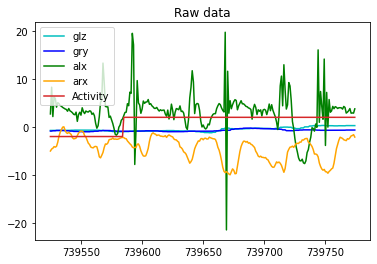

In [8]:
df_target = df.Activity
df = df.drop(columns=["Activity","subject"])

plot_size = 250
tp = 739650
plt_title = "Raw data"
show_plot (df,df_target,plot_size,tp,plt_title)

After median filtered data became more "quet". The large window makes the "jumps" smaller and increases the predictive success. But let's take a small window (size 5) for an interesting challenge.

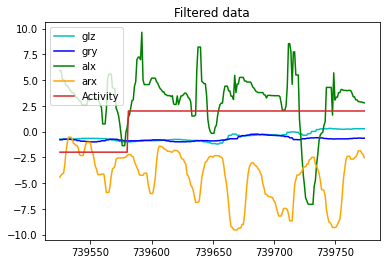

In [9]:
window=5
df_filter, df_target = median_filter(df,df_target,window)


df_filter['Activity'] = df_target
df_filter.index = range(len(df_filter.index))
df_target = df_filter.Activity

plt_title = "Filtered data"
show_plot (df_filter,df_target,plot_size,tp,plt_title)

calculate Activity timing.

In [10]:
Activity_modes = pd.DataFrame(columns=['activity','begin','end', 'duration'])
begin =0
for i in range(1,len(df_target)):
    if df_target[i] != df_target[i-1]:
        row = {'activity': df_target[i-1],"begin": begin, "end": i-1, "duration": i-1-begin}
        Activity_modes = Activity_modes.append( row, ignore_index=True )
        begin = i
print("list of activites:\n",Activity_modes)

list of activites:
     activity    begin      end duration
0          0        0     6651     6651
1          1     6652     9723     3071
2          0     9724    12795     3071
3          2    12796    15867     3071
4          0    15868    18939     3071
..       ...      ...      ...      ...
247       10  1192701  1195772     3071
248        0  1195773  1198844     3071
249       11  1198845  1201916     3071
250        0  1201917  1212617    10700
251       12  1212618  1213641     1023

[252 rows x 4 columns]


Check features quality

* Activity label is not coherent with the real activity measurement.
* Activities #5 and #12 are very short

Between change activity mode and change the lable 'activity' exsist gap of ~1000 samples (~20sec in sample rate 50Hz)


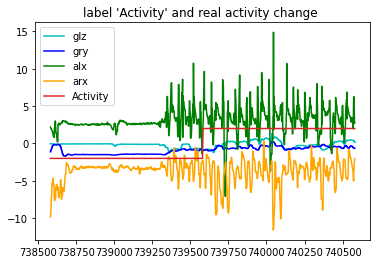

data size df_filter 1215741
activity        12
begin       113404
end         114478
duration      1023
dtype: object
activity         5
begin       157180
end         160251
duration       511
dtype: object
Activities  5 (Climbing stairs) and 12 (Jump front & back) has very short time periods
activity       0
begin          0
end         6651
duration    1023
dtype: object
In several places activity #0 (Standing still ) has very short time periods


In [11]:
plot_size = 2000
print("Between change activity mode and change the lable 'activity' exsist gap of ~1000 samples (~20sec in sample rate 50Hz)")
tp =Activity_modes['begin'][143]
plt_title = "label 'Activity' and real activity change "
show_plot (df_filter,df_target,plot_size,tp,plt_title)

print("data size df_filter",len(df_filter))

print(np.min(Activity_modes[Activity_modes['activity']==12]))
print(np.min(Activity_modes[Activity_modes['activity']==5]))
print("Activities  5 (Climbing stairs) and 12 (Jump front & back) has very short time periods")

print(np.min(Activity_modes[Activity_modes['activity']==0]))
print("In several places activity #0 (Standing still ) has very short time periods")

Downsample all activities to equal amount

In [12]:
from sklearn.utils import resample
 
print("Downsample all activities to equal amount") 

each_act =   2000 # number of indexes of each activity type
print("Size of each activity is", each_act) 
Tmax     = 125 # maximum simulation time (sec)
one_activities_max = min(df_filter.Activity.value_counts())
if each_act > one_activities_max:
    print("Error. Activity sample size exceed maximum value(",one_activities_max,")")

df_mini = resample(df_filter[df_filter.Activity== 0],n_samples=each_act, random_state=42)
for i in range(1,max(df_filter.Activity)+1):
    df_one  = resample(df_filter[df_filter.Activity== i],n_samples=each_act, random_state=42)
    df_mini = pd.concat([df_mini, df_one])


df_mini.index = range(len(df_mini.index))
print("resampled list of activites:\n",df_mini.Activity.value_counts())
df_mini_target = df_mini["Activity"]
df_mini = df_mini.drop(columns=["Activity"])

Downsample all activities to equal amount
Size of each activity is 2000
resampled list of activites:
 0     2000
1     2000
2     2000
3     2000
4     2000
5     2000
6     2000
7     2000
8     2000
9     2000
10    2000
11    2000
12    2000
Name: Activity, dtype: int64


Data normalization and Train/Test separation

In [13]:
#data normalization
df_mini=(df_mini-df_mini.min())/(df_mini.max()-df_mini.min())

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_mini, df_mini_target, test_size=0.3)

**Data processing

KNeighbors**

In [14]:
from sklearn.neighbors import KNeighborsClassifier
n_neighbors = 3
Tstart = time.perf_counter()
KNeighbors = KNeighborsClassifier(n_neighbors = int(n_neighbors) )
KNeighbors.fit(X_train, y_train)
y_pred=KNeighbors.predict(X_test)
KNeighborsscore=metrics.accuracy_score(y_test,y_pred)
diff_vec = y_pred != y_test
err = int(1000*sum(diff_vec)/len(y_pred))/10
Tend = time.perf_counter()
print("KNeighborsC: N", int(n_neighbors), "error", err, "%, Tcalc=", int(Tend - Tstart), "sec","Accuracy score:  ",KNeighborsscore*100)    

KNeighborsC: N 3 error 7.6 %, Tcalc= 0 sec Accuracy score:   92.3974358974359


Logistic regression


In [15]:
from sklearn.linear_model import LogisticRegression
C =1000
logistic_regression= LogisticRegression(max_iter=50000, C=C)
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)
LogisticRegressionscore=metrics.accuracy_score(y_test,y_pred)
diff_vec = y_pred != y_test
err = int(1000*sum(diff_vec)/len(y_pred))/10
print("LogisticRegression: C", C, "error", err, "%","Accuracy score: ",LogisticRegressionscore*100)   

LogisticRegression: C 1000 error 43.1 % Accuracy score:  56.8974358974359


Support Vector classification algorithm

In [16]:
from sklearn import svm
C = 1000
gamma = 10
SVM_type = 'rbf'      
print(SVM_type, " calculation")
Tstart = time.perf_counter()
model = svm.SVC(kernel=SVM_type, gamma=gamma, C=C)
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
svmscore=metrics.accuracy_score(y_test,y_pred)
diff = np.array(y_pred) != y_test #).flatten()
err = int(1000*sum(diff)/len(y_test))/10
Tend = time.perf_counter()
print("SVC: C", C, "gamma",gamma, "error", err, "%, Tcalc=", int(Tend - Tstart), "sec","Accuracy score: ",svmscore*100)

rbf  calculation
SVC: C 1000 gamma 10 error 6.0 %, Tcalc= 5 sec Accuracy score:  93.97435897435898


Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier
n_est = 800
max_d = 7
Tstart = time.perf_counter()
reg = RandomForestClassifier(n_estimators=int(n_est), max_depth=int(max_d), random_state=0)
reg.fit(X_train, y_train)
y_pred =  reg.predict(X_test)
RandomForestClassifierscore=metrics.accuracy_score(y_test,y_pred)
diff_vec = y_pred != y_test
err = int(1000*sum(diff_vec)/len(y_pred))/10
Tend = time.perf_counter()
print("RandomForestC", "n_est", n_est,"max_d", max_d ,"error", err, "%, Tcalc=", int(Tend - Tstart), "sec","Accuracy score: ",RandomForestClassifierscore*100)

RandomForestC n_est 800 max_d 7 error 19.6 %, Tcalc= 27 sec Accuracy score:  80.3076923076923


Gradient Descent Algorithm

In [18]:
from sklearn.ensemble import GradientBoostingClassifier
n_est = 55
max_d = 7
Tstart = time.perf_counter()
reg = GradientBoostingClassifier(n_estimators=int(n_est), max_depth=int(max_d), random_state=0)
reg.fit(X_train, y_train)
y_pred =  reg.predict(X_test)
GradientBoostingClassifierscore=metrics.accuracy_score(y_test,y_pred)
diff_vec = y_pred != y_test
err = int(1000*sum(diff_vec)/len(y_pred))/10
Tend = time.perf_counter()
print("GradientBC", "n_est", n_est,"max_d", max_d ,"error", err, "%, Tcalc=", int(Tend - Tstart), "sec","Accuracy score: ",GradientBoostingClassifierscore*100)

GradientBC n_est 55 max_d 7 error 6.6 %, Tcalc= 118 sec Accuracy score:  93.3974358974359


In [19]:
error_investigation = pd.DataFrame(columns=['test', 'pred', 'err'])
error_investigation['test'] = y_test
error_investigation['pred'] = y_pred
error_investigation[ 'err'] = diff_vec

Failed = error_investigation[error_investigation[ 'err'] == True]
Failed.index = range(len(Failed))
activity_labels = {
    0: "None",
    1: "Standing still (1 min)",
    2: "Sitting and relaxing (1 min)",
    3: "Lying down (1 min)",
    4: "Walking (1 min)",
    5: "Climbing stairs (1 min)",
    6: "Waist bends forward (20x)",
    7: "Frontal elevation of arms (20x)",
    8: "Knees bending (crouching) (20x)",
    9: "Cycling (1 min)",
    10: "Jogging (1 min)",
    11: "Running (1 min)",
    12: "Jump front & back (20x)"
}
Ftest = Failed.test.value_counts()
print("Error summary:")
for i in Ftest.index :
    proc = int(1000*Ftest[i]/each_act)/10
    print(proc,"%", " ", "(#%2d" %i,")",  activity_labels[i] )

Error summary:
11.7 %   (# 0 ) None
3.0 %   (#10 ) Jogging (1 min)
2.9 %   (# 5 ) Climbing stairs (1 min)
2.1 %   (#12 ) Jump front & back (20x)
1.8 %   (#11 ) Running (1 min)
1.1 %   (# 8 ) Knees bending (crouching) (20x)
1.0 %   (# 4 ) Walking (1 min)
0.9 %   (# 6 ) Waist bends forward (20x)
0.3 %   (# 7 ) Frontal elevation of arms (20x)
0.3 %   (# 9 ) Cycling (1 min)
0.2 %   (# 2 ) Sitting and relaxing (1 min)
0.1 %   (# 1 ) Standing still (1 min)
0.0 %   (# 3 ) Lying down (1 min)


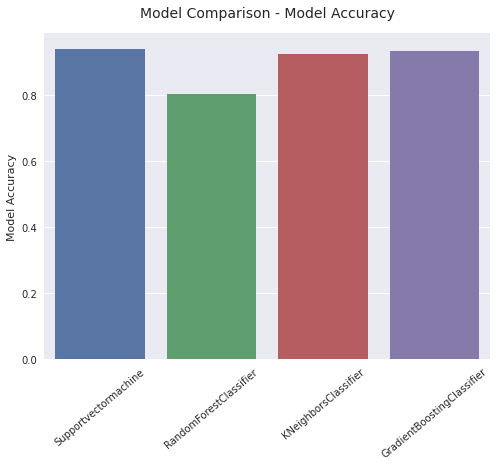

In [20]:
import seaborn as sns
plt.style.use("seaborn")

x = [
     "Supportvectormachine", 
     "RandomForestClassifier", 
     "KNeighborsClassifier", 
     "GradientBoostingClassifier"]

y = [
     svmscore, 
     RandomForestClassifierscore, 
     KNeighborsscore, 
     GradientBoostingClassifierscore]

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=x,y=y);
plt.ylabel("Model Accuracy")
plt.xticks(rotation=40)
plt.title("Model Comparison - Model Accuracy", fontsize=14, fontname="Helvetica", y=1.03);